In [4]:
import random
import math
import numpy as np
from deap import base, creator, tools, algorithms
import torch
import matplotlib.pyplot as plt

# 随机种子设置
def set_seed(seed):
    np.random.seed(seed)  # numpy产生的随机数一致
    random.seed(seed)

set_seed(42)

In [5]:
def generate_random_subsets(array, subset_count, subset_size):
    subsets = []
    for _ in range(subset_count):
        subset = random.sample(array, subset_size)
        subsets.append(subset)
    
    return subsets

def probability_majority_one(probabilities):
    n = len(probabilities)
    half = math.ceil(n / 2)
    if n % 2 == 0:
        half += 1

    # Initialize dp table
    dp = [[0] * (n + 1) for _ in range(n + 1)]
    dp[0][0] = 1

    # Fill dp table
    for i in range(1, n + 1):
        p = probabilities[i - 1]
        for j in range(i + 1):
            if j == 0:
                dp[i][j] = dp[i - 1][j] * (1 - p)
            else:
                dp[i][j] = dp[i - 1][j] * (1 - p) + dp[i - 1][j - 1] * p

    # Sum probabilities of having more than half 1s
    result = sum(dp[n][j] for j in range(half, n + 1))
    return result


def evaluate(individual, probabilities, threshold, num_subsets):
    subsets = [[] for _ in range(num_subsets)]
    
    # Distribute probabilities to subsets according to individual
    for i in range(len(probabilities)):
        subset_index = individual[i]
        if subset_index < num_subsets:
            subsets[subset_index].append(probabilities[i])
    
    valid_subsets = 0
    total_size = 0

    for subset in subsets:
        if probability_majority_one(subset) > threshold:
            valid_subsets += 1
            total_size += len(subset)

    if valid_subsets == num_subsets:
        return (total_size,)
    else:
        return (float('inf'),)
    
def generate_normal_random_numbers(count, mean, std_dev):
    random_numbers = np.empty(count)
    generated_count = 0

    while generated_count < count:
        remaining_count = count - generated_count
        new_numbers = np.random.normal(
            loc=mean, scale=std_dev, size=remaining_count
        )
        valid_numbers = new_numbers[(new_numbers >= 0) & (new_numbers <= 1)]

        valid_count = len(valid_numbers)
        random_numbers[generated_count : generated_count + valid_count] = (
            valid_numbers
        )
        generated_count += valid_count

    return random_numbers

In [6]:
def random_algo(probabilities, num_subsets):
    subsets = generate_random_subsets(probabilities, num_subsets, 3)
    ret = []
    for subset in subsets:
        ret.append((subset, probability_majority_one(subset)))
    return ret


def our_algo_init():
    # Define the fitness and individual types
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)


def our_algo(reputations, probabilities, threshold, num_subsets):
    n = len(reputations)

    # Initialize toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_int", random.randint, 0, num_subsets)
    toolbox.register(
        "individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n
    )
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register genetic operators
    toolbox.register(
        "evaluate",
        evaluate,
        probabilities=reputations,
        threshold=threshold,
        num_subsets=num_subsets,
    )
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=num_subsets, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Create initial population
    population = toolbox.population(n=300)

    # Set genetic algorithm parameters
    ngen = 500  # Increase the number of generations
    cxpb = 0.7  # Crossover probability
    mutpb = 0.3  # Mutation probability

    # Run genetic algorithm
    algorithms.eaSimple(
        population,
        toolbox,
        cxpb,
        mutpb,
        ngen,
        stats=None,
        halloffame=None,
        verbose=False,
    )

    # Get the best individual
    best_ind = tools.selBest(population, 1)[0]

    # Decode the best individual into subsets
    subsets = [[] for _ in range(num_subsets)]
    for i in range(len(probabilities)):
        subset_index = best_ind[i]
        if subset_index < num_subsets:
            subsets[subset_index].append(probabilities[i])

    # print("Probabilities:", probabilities)
    ret = []
    for idx, subset in enumerate(subsets):
        if subset:
            ret.append((subset, probability_majority_one(subset)))
    return ret


if __name__ == "__main__":
    our_algo_init()
    num_subsets = 3

    # 获取实际诚实性数据
    actual_honest = [0.99 for _ in range(40)]
    actual_fr = [0.1 for _ in range(40)]
    actual_malicious = [0.99 for _ in range(20)] + [0 for _ in range(20)]

    # 获取信誉值数据
    avg_reps = torch.load("./avg_rep")
    for i, (rep_honest, rep_fr, rep_malicious) in enumerate(
        zip(avg_reps["honest"], avg_reps["Free-rider"], avg_reps["Malicious"])
    ):
        if i < 10:
            continue
        if i % 5 != 0:
            continue
        reputations = (
            [rep_honest for _ in range(10)]
            + [rep_fr for _ in range(10)]
            + [rep_malicious for _ in range(10)]
        )
        probabilities = (
            [actual_honest[i] for _ in range(10)]
            + [actual_fr[i] for _ in range(10)]
            + [actual_malicious[i] for _ in range(10)]
        )

        ret_ours = our_algo(reputations, probabilities, 0.9, num_subsets)
        ret_random = random_algo(probabilities, num_subsets)

        print(i)
        print(ret_ours)
        print(ret_random)

/root/miniconda3/envs/py38/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/root/miniconda3/envs/py38/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


KeyboardInterrupt: 

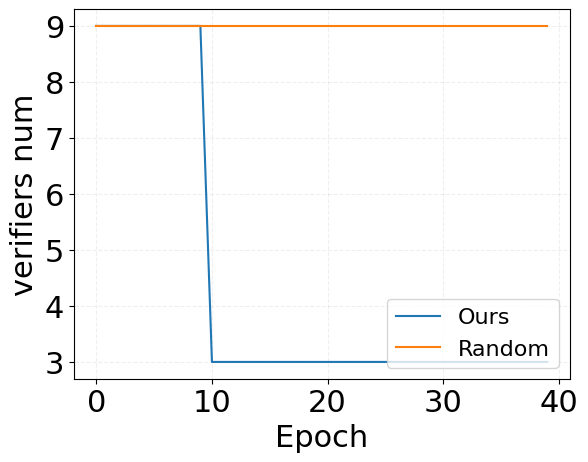

In [7]:
ours_num = [3*3 for _ in range(10)] + [1*3 for _ in range(30)]
random_num = [3*3 for _ in range(40)]

plt.figure()
plt.yticks(fontsize=22)
plt.xticks(np.arange(0, 41, 10), fontsize=22)
plt.plot(ours_num, label="Ours")
plt.plot(random_num, label="Random")

plt.xlabel("Epoch", fontsize=22)
plt.ylabel("verifiers num", fontsize=22)
plt.ylim(0, 10)  # Set y-axis range to 0-1
plt.legend(loc="lower right", fontsize=16)
plt.grid(ls="--", alpha=0.2)
plt.savefig(f"commitee_num.pdf", dpi=300, bbox_inches="tight")